### Planteamiento del problema

En el dia a dia, es comun trabajar con bases de datos incompletas, e infomación básica como la edad o fecha de nacimiento de los individuos resulta importante para llevar a cabo diversos análisis estadísticos. 

Por otra parte en Chile, cada ciudadano cuenta con un Rol unico nacional (Run) que se asigna al momento de la inscripción en el registro civil. Este consta de 2 partes: Por un lado un numero entero que se crea en forma ascendente y no correlativa, a través de un algoritmo. Y por otra un digito verificador que utiliza los digitos del 0 al 9 y la letra "K" que representa al numero 11 y que permite validar dicho conjunto de caracteres como un Run generado por el Registro Civil. 

Dado que la inscripción en el registro Civil se historicamente en fechas cercanas al nacimiento de cada individuo, es esperable una correlacion entre el componente entero del Run y la edad de cada individuo. Con la excepción de los ciudadanos migrantes a quienes se les asigna un Run, no correlativo y que normalmente es cerca de 10 millones mayor al de los Run generados para los ciudadanos nacidos en chile. Si se tienen nociones de las nacionalidades de los ciudadanos, esto permitiría mejorar la calidad de los datos y facilitar el análisis estadistico de bases incompletas. 

#### Obtención de los Datos

Para el analisis se realizó una busqueda manual en Google, utilizando herramientas de busqueda avanzada para archivos .pdf y .xlsx que contuvieran tanto el Run, como fecha de nacimiento de ciudadanos chilenos.Se identificaron <b>2087</b> Run con sus respectivas fechas de nacimiento. Los datos fueron importados y consolidados mediante Microsoft Excel e importados a R para su procesamiento. Dado que el Run corresponde a un dato identificatorio, no se disponibilizará la base de datos para este proyecto. 

### Procesamiento en R
Comenzamos importando las librerias a utilizar. 

In [1]:
library(tidyverse) #importamos el "pipeline", así como dplyr la que incorpora funciones como mutate() para la transformación de datos. 
library(lubridate) #Librería para la manipulacion de datos correspondientes a fechas. 
library(readxl)  #libreria para importar archivos desde Microsoft Excel y para la creación de archivos .xlsx
library(scales)  #libreria que usada en conjunto con ggplot, permite dar formato a los ejes de los graficos a generar.

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: timechange


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [29]:
data<-readxl::read_xlsx(path="Datos/Datos_run_edad.xlsx",sheet="Run")

In [33]:

#Tomamos unicamente las columnas Run y Fecha de nacimiento y realizamos el calculo de la edad
data<-data[c("Run","Fecha_nacimiento")] %>% 
  dplyr::mutate(Edad=floor((Fecha_nacimiento %--% today()) / years(1)))
#Evaluamos la correlación entre el Run y ambas variables.
print("Correlacion entre Run y Edad")
cor(x=data$Run, y=data$Edad) 
print("Correlacion entre Run y Año de nacimiento")
cor(x=data$Run, y=year(data$Fecha_nacimiento))

[1] "Correlacion entre Run y Edad"


[1] -0.9873559

[1] "Correlacion entre Run y Año de nacimiento"


[1] 0.9873484

<li>Observamos una fuerte correlacion negativa entre Run y edad, cercana a -1 (-0.9873).</li>
<li>Observamos una fuerte correlacion positiva entre Run y Año de nacimiento, cercana a 1 (0.9873).</li>

Graficamos ambas variables para apreciar mas claramente dicha relación. 

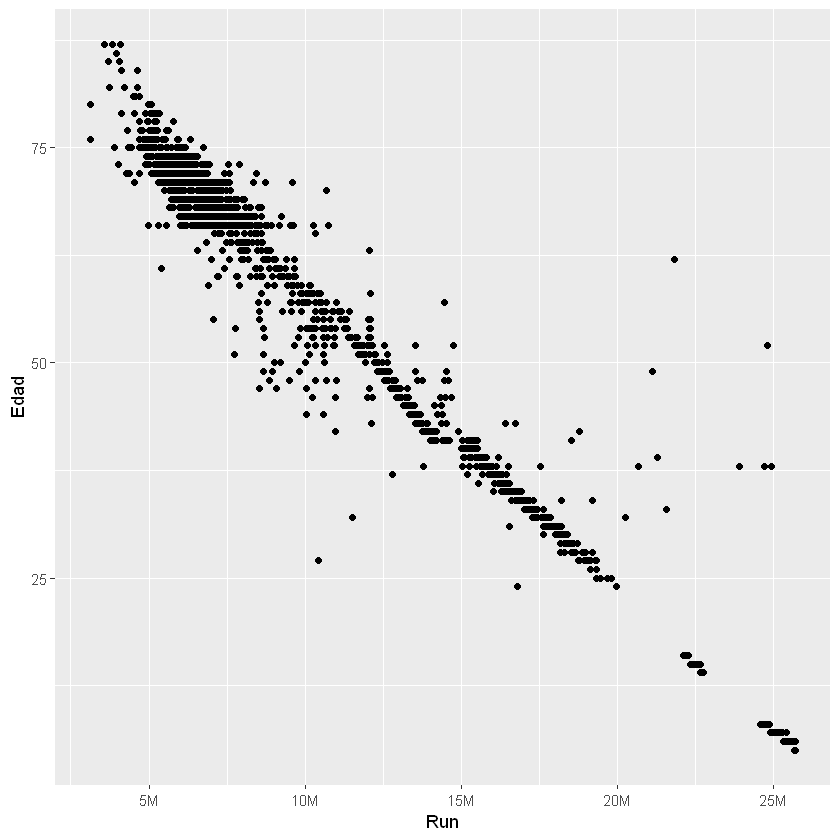

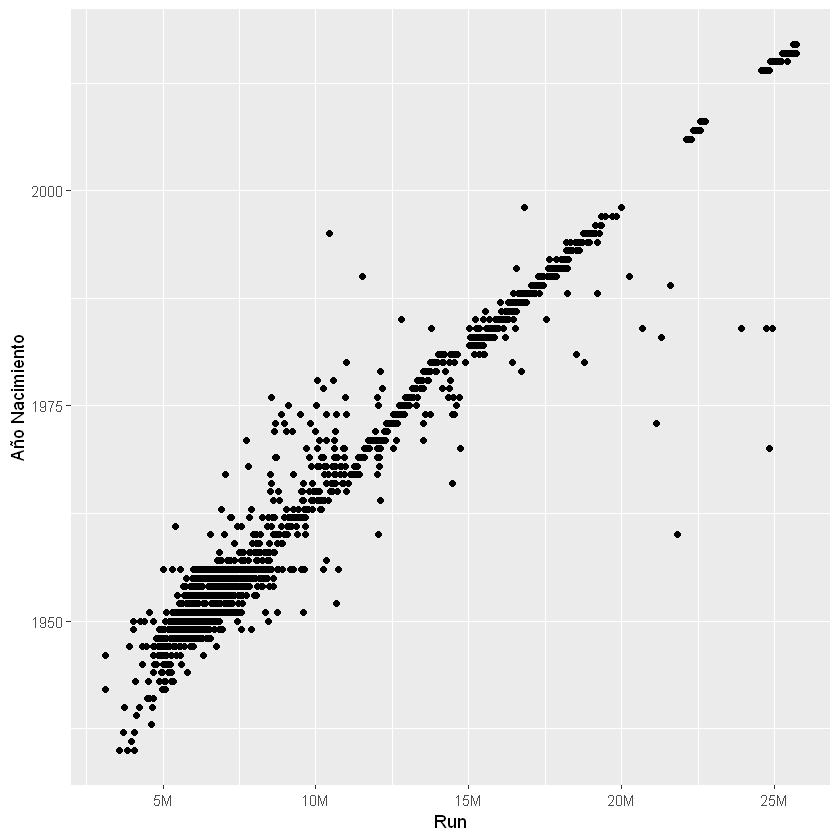

In [34]:
ggplot(data=data, aes(x=Run, y=Edad))+
    geom_point()+
   scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))

ggplot(data=data, aes(x=Run, y=year(Fecha_nacimiento)))+
    geom_point()+
   scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))+
    labs(y="Año Nacimiento")

*observamos algunos outliers en en aquellas personas con Run>20M quienes provablemente correspondan a ciudadanos migrantes. 

Dada la distribución observada, planteamos un modelo de regresion lineal simple dado que estudiamos la correlacion entre 2 variables.

In [35]:
modelo<-lm(Edad ~ Run, data=data)

summary(modelo)


Call:
lm(formula = Edad ~ Run, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.489  -1.183  -0.113   1.302  44.115 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.170e+01  1.216e-01   754.3   <2e-16 ***
Run         -3.377e-06  1.021e-08  -330.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.053 on 2817 degrees of freedom
Multiple R-squared:  0.9749,	Adjusted R-squared:  0.9749 
F-statistic: 1.093e+05 on 1 and 2817 DF,  p-value: < 2.2e-16


En base al resumen del modelo se establece la ecuación para la recta ajustada a la muestra como:
#### Edad = 9.170e+01 -3.377e-06 * Run
con un valor p de <0.05. Lo que determina que es muy poco probable que la distribucion de la muestra se deba al azar. 

`geom_smooth()` using formula = 'y ~ x'


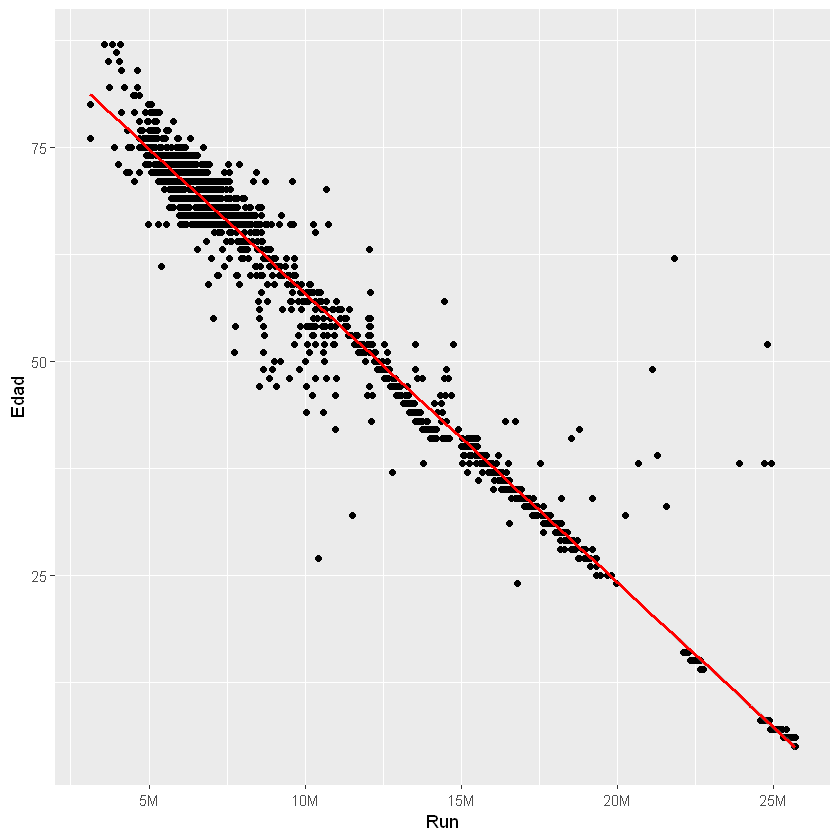

In [40]:
#Visualizamos la recta obtenida por la regresion lineal
ggplot(data=data, aes(x=Run, y=Edad))+
    geom_point()+
   scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))+
    geom_smooth(method="lm", color="red")


Utilizaremos el modelo obtenido para predecir la edad de algunos Run.

In [41]:
predecir<-data.frame(Run=c(16093705,18907185, 17031040)) 
predecir<-predecir %>% 
  mutate(Edad=floor(predict(modelo, newdata = predecir)))

predecir

Run,Edad
<dbl>,<dbl>
16093705,37
18907185,27
17031040,34


Finalmente graficamos los puntos predichos.

`geom_smooth()` using formula = 'y ~ x'


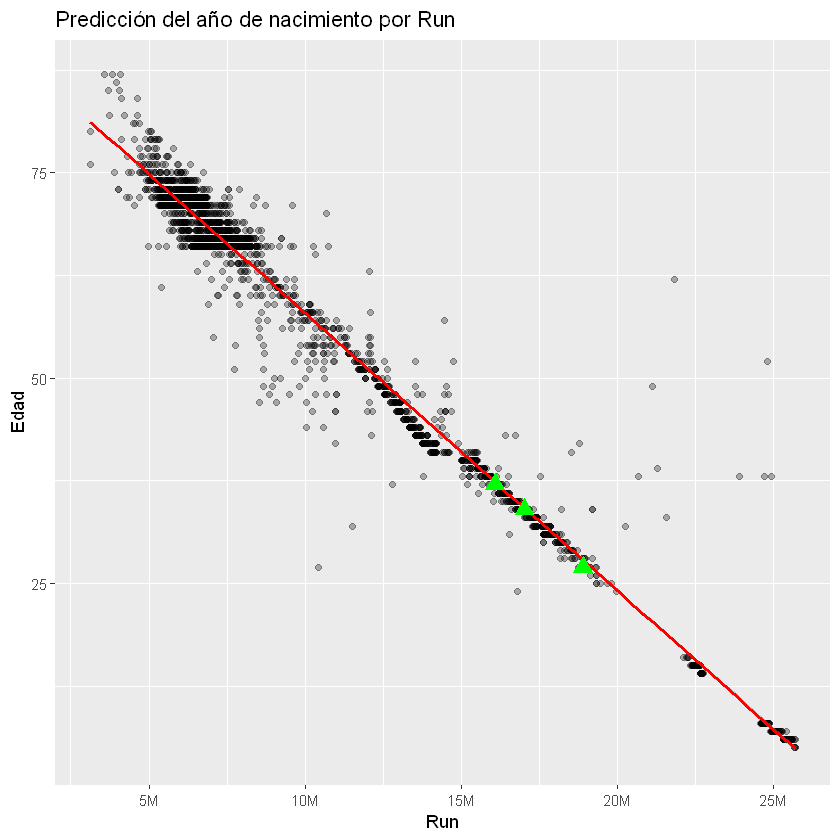

In [42]:
ggplot(data=data,aes(x=Run, y=Edad))+
  scale_x_continuous("Run",labels = scales::label_number(scale_cut = scales::cut_short_scale()))+
geom_point(alpha=0.3)+
geom_smooth(method="lm", color="red")+
  labs(title="Predicción del año de nacimiento por Run", 
       x="Run", 
       y="Edad"
       )+
geom_point(data=predecir,aes(Run, Edad), color="green", size=4, shape=17)

Por tanto podemos concluir que podremos inferir la edad en ciudadanos Chilenos en base a su run aplicando la formula anteriormente descrita, agregamos la resta del año 2023 (en que se realiza el calculo) al año actual para ajustar la formula al paso del tiempo lo que nos deja:
<br>
#### Edad = 9.170e+01 + 2023 - (year(today()) - 3.377e-06 * Run